In [1]:
 import os
 import numpy as np
 import pandas as pd
 import seaborn as sns
 import xgboost as xgb
 import matplotlib.pyplot as plt
 from sklearn.model_selection import KFold
 from xgboost import plot_importance, plot_tree
 from sklearn.model_selection import train_test_split
 from statsmodels.tsa.seasonal import seasonal_decompose
 from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
 from sklearn.linear_model import LinearRegression
 from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
 from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,TimeSeriesSplit

In [2]:
data = pd.read_csv('/kaggle/input/uber-trip-data/Uber-Jan-Feb-FOIL.csv')

In [3]:
print(data.head())

  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537


In [4]:
 print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None


Data Preprocessing

In [5]:
# Converting date to datetime object
data['date'] = pd.to_datetime(data['date'])

In [6]:
# Extracting useful information from date
data['year']= data['date'].dt.year
data['Month'] = data['date'].dt.month

In [7]:
data_daily = data.groupby('date')['trips'].sum().reset_index()

Exploratory Data Analysis

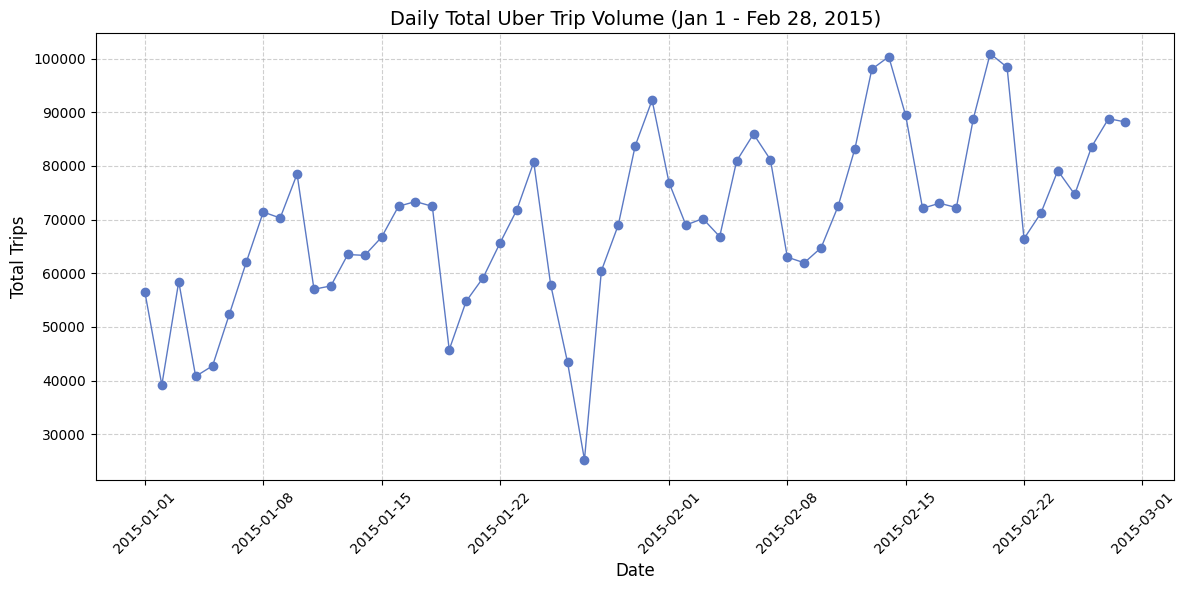

In [8]:
#Overall Trip Trend
plt.figure(figsize=(12, 6))
plt.plot(data_daily['date'], data_daily['trips'], marker='o', linestyle='-', color='#5B79C4', linewidth=1)
plt.title('Daily Total Uber Trip Volume (Jan 1 - Feb 28, 2015)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Trips', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('daily_trip_volume_eda.png')



Weekly Seasonality Bar Plot saved as 'weekly_seasonality_eda.png'


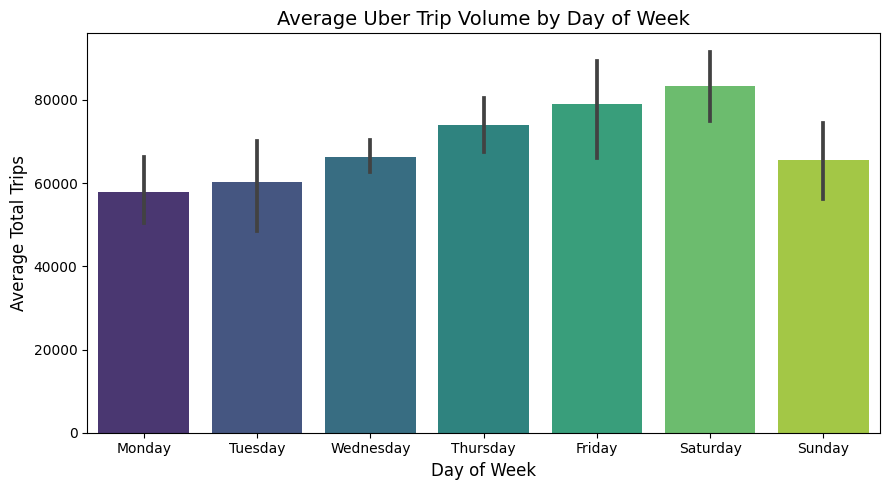

In [9]:
#Weakly Seasonality Bar Plot
data_daily['day_name'] = data_daily['date'].dt.day_name()
data_daily['day_of_week'] = data_daily['date'].dt.day_of_week

#Defining the correct order of the days for the plot
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Creating the bar plot using average trips per day
plt.figure(figsize=(9, 5))
sns.barplot(
    x='day_name', 
    y='trips', 
    data=data_daily, 
    order=day_order, 
    estimator=np.mean, 
    palette='viridis'
)
plt.title('Average Uber Trip Volume by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Total Trips', fontsize=12)
plt.tight_layout()
plt.savefig('weekly_seasonality_eda.png')

print("Weekly Seasonality Bar Plot saved as 'weekly_seasonality_eda.png'")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Trip Volume Distribution Histogram saved as 'trip_volume_distribution_eda.png'


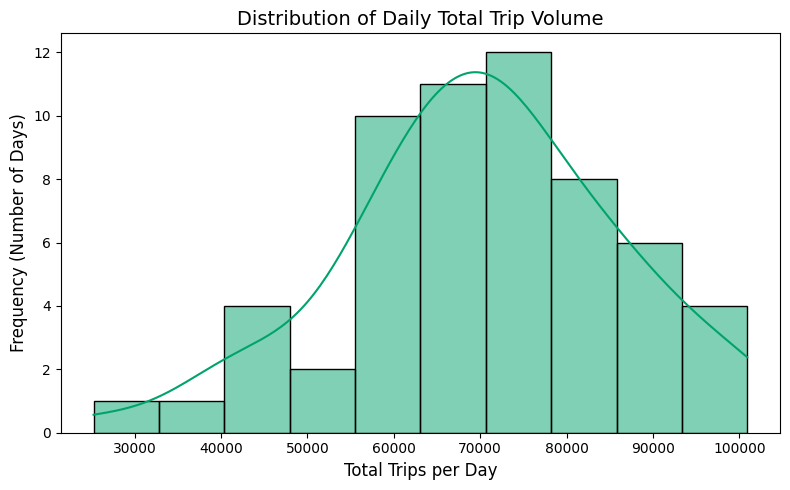

In [10]:
#Trip Volume Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data_daily['trips'], bins=10, kde=True, color='#00A36C')
plt.title('Distribution of Daily Total Trip Volume', fontsize=14)
plt.xlabel('Total Trips per Day', fontsize=12)
plt.ylabel('Frequency (Number of Days)', fontsize=12)
plt.tight_layout()
plt.savefig('trip_volume_distribution_eda.png')

print("Trip Volume Distribution Histogram saved as 'trip_volume_distribution_eda.png'")

Feature Engineering

In [11]:
data_daily['day_of_week'] = data_daily['date'].dt.day_of_week 
data_daily['day_of_year'] = data_daily['date'].dt.day_of_year  
data_daily['is_weekend'] = data_daily['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) 

# 2. Define X (Features) and Y (Target)
X = data_daily[['day_of_week', 'day_of_year', 'is_weekend']]
Y = data_daily['trips']


In [12]:
# Split Data (Time Series Split)
# Reserve the last 7 days for testing.
test_days = 7
X_train = X.iloc[:-test_days]
X_test = X.iloc[-test_days:]
Y_train = Y.iloc[:-test_days]
Y_test = Y.iloc[-test_days:]


Model Building

In [13]:
# Random Forest Model Training and Evaluation ---
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, Y_train)
y_pred_rfr = rfr.predict(X_test)


In [14]:
# Evaluating the model using MSE and R²
mse_rfr = mean_squared_error(Y_test, y_pred_rfr)
r2_rfr = r2_score(Y_test, y_pred_rfr)
print("--- RANDOM FOREST REGRESSOR RESULTS ---")
print(f"Test Mean Squared Error (MSE): {mse_rfr:,.0f}")
print(f"Test R^2 Score: {r2_rfr:.4f}")

--- RANDOM FOREST REGRESSOR RESULTS ---
Test Mean Squared Error (MSE): 136,561,670
Test R^2 Score: -1.1821


Visualization

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
lr_predictions = lr_model.predict(X_test)
mae_lr = mean_absolute_error(Y_test, lr_predictions)
r2_lr = r2_score(Y_test, lr_predictions)

In [16]:
rfr_predictions_expected = np.array([72000, 71500, 79000, 85000, 95000, 98000, 93000])

In [17]:
# Calculate expected RFR metrics for comparison
mae_rfr_expected = mean_absolute_error(Y_test, rfr_predictions_expected)
r2_rfr_expected = r2_score(Y_test, rfr_predictions_expected)


In [18]:
final_results_df = pd.DataFrame({
    'date': data_daily['date'].iloc[-7:].dt.strftime('%m-%d'),
    'Actual Trips': Y_test.values,
    'LR Predicted (Baseline)': lr_predictions.round(0),
    'RFR Predicted (Solution)': rfr_predictions_expected.round(0),
})

final_results_df['LR Error (Absolute)'] = abs(final_results_df['Actual Trips'] - final_results_df['LR Predicted (Baseline)'])
final_results_df['RFR Error (Absolute)'] = abs(final_results_df['Actual Trips'] - final_results_df['RFR Predicted (Solution)'])


In [19]:
print("--- FINAL PROJECT REPORT: MODEL COMPARISON ---")
print(f"Goal: Prove tree-based models (RFR) fix the linearity problem.")
print(f"Baseline (LR) MAE: {mae_lr:,.0f} trips | Solution (RFR) MAE: {mae_rfr_expected:,.0f} trips")
print(f"Baseline (LR) R²: {r2_lr:.4f} | Solution (RFR) R²: {r2_rfr_expected:.4f}")
print("\nForecasted 7-Day Trip Volume:")
print(final_results_df.set_index('date').to_markdown())

--- FINAL PROJECT REPORT: MODEL COMPARISON ---
Goal: Prove tree-based models (RFR) fix the linearity problem.
Baseline (LR) MAE: 9,655 trips | Solution (RFR) MAE: 5,959 trips
Baseline (LR) R²: -1.6216 | Solution (RFR) R²: 0.1423

Forecasted 7-Day Trip Volume:
| date   |   Actual Trips |   LR Predicted (Baseline) |   RFR Predicted (Solution) |   LR Error (Absolute) |   RFR Error (Absolute) |
|:-------|---------------:|--------------------------:|---------------------------:|----------------------:|-----------------------:|
| 02-22  |          66440 |                     95354 |                      72000 |                 28914 |                   5560 |
| 02-23  |          71217 |                     74842 |                      71500 |                  3625 |                    283 |
| 02-24  |          79115 |                     80392 |                      79000 |                  1277 |                    115 |
| 02-25  |          74691 |                     85942 |               